In [1]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
%matplotlib widget

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight

        def observation_update(self, observation, env_map, distance_dev_rate, direction_dev):
            print(observation)

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + \
            ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl:
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn": 0.19, "no": 0.001, "on": 0.13, "oo": 0.2},
                 distance_dev_rate=0.14, direction_dev=0.05):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)

    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)

    def observation_update(self, observation):
        print(observation)

    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles]
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, angles='xy', scale_units='xy', color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def decision(self, observation=None):
        self.estimator.motion_update(
            self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega

    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

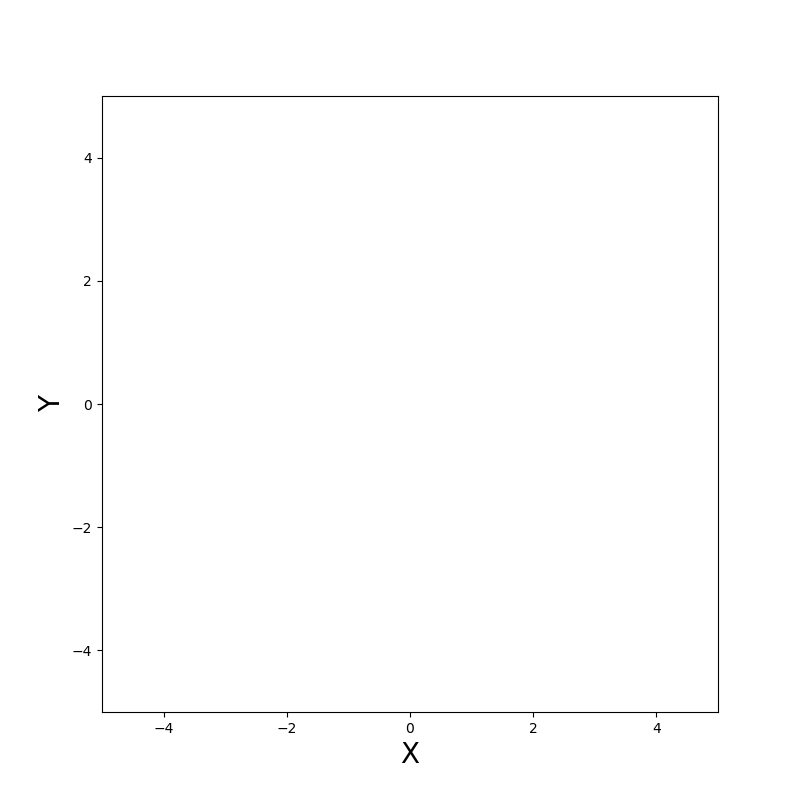

[(array([ 3.24960286, -1.00662729]), 1), (array([3.91164329, 0.74711452]), 2)]
[(array([ 3.25720336, -0.99209089]), 1), (array([3.87528008, 0.73824399]), 2)]
[(array([3.80313928, 0.67827267]), 2)]
[]
[(array([3.86400278, 0.71444806]), 2)]
[]
[(array([3.8439745 , 0.63098657]), 2)]
[(array([3.89928876, 0.66279275]), 2)]
[(array([3.84640872, 0.68237281]), 2)]
[(array([3.88466033, 0.60508612]), 2)]
[(array([3.68838947, 0.57648506]), 2)]
[(array([3.77016088, 0.57080824]), 2)]
[(array([3.68564276, 0.67437808]), 2)]
[(array([3.57613603, 0.59408355]), 2)]
[(array([3.80714628, 0.54496573]), 2)]
[(array([3.64972437, 0.52785439]), 2)]
[(array([3.7448074 , 0.54708472]), 2)]
[(array([3.65339792, 0.53185586]), 2)]
[(array([3.56979415, 0.49641037]), 2)]
[(array([3.542546  , 0.48816349]), 2)]
[]
[(array([3.60916108, 0.50180551]), 2)]
[(array([3.75111224, 0.4200389 ]), 2)]
[(array([3.39656331, 0.4569338 ]), 2)]
[(array([3.74810638, 0.42845853]), 2)]
[(array([3.67356616, 0.43594349]), 2)]
[]
[(array([3.

In [5]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)

    m = Map()
    for ln in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)

    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(m, initial_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

trial()